# notebook instructions

suggest run in local venv with python 3.10, packages as below:
absl-py==1.4.0
anyio==4.9.0
appnope==0.1.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
cloudpickle==3.1.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
diffprivlib==0.6.5
dm-tree==0.1.8
dp-accounting==0.4.3
exceptiongroup==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.18.0
flatbuffers==25.2.10
fonttools==4.56.0
fqdn==1.5.1
fsspec==2025.3.0
gast==0.6.0
google-pasta==0.2.0
grpcio==1.71.0
h11==0.14.0
h5py==3.13.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
ipykernel==6.29.5
ipython==8.34.0
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.10.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-events==0.12.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.15.0
jupyter_server_terminals==0.5.3
jupyterlab==4.3.6
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
keras==3.9.0
kiwisolver==1.4.8
libclang==18.1.1
Markdown==3.7
markdown-it-py==3.0.0
MarkupSafe==3.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
mdurl==0.1.2
mistune==3.1.3
ml_dtypes==0.5.1
mpmath==1.3.0
namex==0.0.8
nbclient==0.10.2
nbconvert==7.16.6
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.4.2
notebook==7.3.3
notebook_shim==0.2.4
numpy==1.26.4
opacus==1.5.3
opt_einsum==3.4.0
optree==0.14.1
overrides==7.7.0
packaging==22.0
pandas==2.2.3
pandocfilters==1.5.1
parso==0.8.4
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.3.7
prometheus_client==0.21.1
prompt_toolkit==3.0.50
protobuf==5.29.4
psutil==7.0.0
ptyprocess==0.7.0
pure_eval==0.2.3
pycparser==2.22
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
python-json-logger==3.3.0
pytz==2025.1
PyYAML==6.0.2
pyzmq==26.3.0
referencing==0.36.2
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rich==13.9.4
rpds-py==0.23.1
scikit-learn==1.6.1
scipy==1.15.2
seaborn==0.13.2
Send2Trash==1.8.3
six==1.17.0
sniffio==1.3.1
soupsieve==2.6
stack-data==0.6.3
sympy==1.13.1
tensorboard==2.19.0
tensorboard-data-server==0.7.2
tensorflow==2.19.0
tensorflow-estimator==2.15.0
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-probability==0.22.1
tensorflow_privacy==0.9.0
termcolor==2.5.0
terminado==0.18.1
threadpoolctl==3.6.0
tinycss2==1.4.0
tomli==2.2.1
torch==2.6.0
torchvision==0.21.0
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20241206
typing_extensions==4.12.2
tzdata==2025.2
uri-template==1.3.0
urllib3==2.3.0
wcwidth==0.2.13
webcolors==24.11.1
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.1.3
wrapt==1.17.2

# import and libraries

In [ ]:
! pip install torch torchvision tqdm scikit-learn matplotlib

In [53]:
import numpy as np
import torch
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
from torch import nn, optim
from opacus import PrivacyEngine

In [54]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# prepare data

In [56]:
# Prepare dataset
train_set = CIFAR10(root='./cifar10', train=True, download=True, transform=ToTensor())
test_set = CIFAR10(root='./cifar10', train=False, download=True, transform=ToTensor())

In [58]:
class AppendDataset(Dataset):
    '''
    Appends a constant label to all data-points in a dataset.
    '''
    def __init__(self, ds, y):
        self._ds = ds
        self._y = y

    def __getitem__(self, idx):
        x = self._ds[idx]
        return x, self._y

    def __len__(self):
        return len(self._ds)

In [ ]:
# Assign True = member for train set and False = non-member for test set
mia_test_set = ConcatDataset([AppendDataset(train_set, True), AppendDataset(test_set, False)])
mia_test_set_labels = np.array([i[1] for i in mia_test_set])
print (mia_test_set_labels)

[ True  True  True ... False False False]


# models

## model definition - simple CNN

In [59]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(128*2*2, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    return model

In [60]:
# ========== Configuration ==========
BATCH_SIZE = 50
EPOCHS = 50
LR = 1e-3
EPSILON = 1.0
DELTA = 1e-5
MAX_GRAD_NORM = 1.0
USE_DP = False  # Toggle this for using Differential Privacy

In [61]:
# ========== Data Loaders ==========
def get_dataloaders(train_set, test_set, batch_size=BATCH_SIZE):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    return train_loader, test_loader

# ========== Training ==========
def train(dataloader, model, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_func(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{(batch+1)*len(X):>5d}/{size:>5d}]")

# ========== Testing ==========
def test(dataloader, model, loss_func):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = test_loss / num_batches
    accuracy = 100 * correct / size
    print(f"Test Error: \n Accuracy: {accuracy:.1f}%, Avg loss: {avg_loss:.6f} \n")

# ========== Training Loop ==========
def train_and_evaluate(model, train_loader, test_loader, use_dp=False, epsilon=EPSILON, delta=DELTA, max_grad_norm=MAX_GRAD_NORM):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    if use_dp:
        privacy_engine = PrivacyEngine()
        model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            epochs=EPOCHS,
            target_epsilon=epsilon,
            target_delta=delta,
            max_grad_norm=max_grad_norm,
        )

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_loader, model, criterion, optimizer)
        test(test_loader, model, criterion)
    print("Training Complete.\n")

## train model_non_dp

In [62]:
train_loader, test_loader = get_dataloaders(train_set, test_set)

# Without Differential Privacy
model_non_dp = get_model()
train_and_evaluate(model_non_dp, train_loader, test_loader, use_dp=False)


Epoch 1
-------------------------------
loss: 2.297081  [   50/50000]
loss: 1.949974  [ 5050/50000]
loss: 1.847571  [10050/50000]
loss: 1.913990  [15050/50000]
loss: 1.715324  [20050/50000]
loss: 1.604204  [25050/50000]
loss: 1.539336  [30050/50000]
loss: 1.584373  [35050/50000]
loss: 1.433776  [40050/50000]
loss: 1.373227  [45050/50000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.372078 

Epoch 2
-------------------------------
loss: 1.605410  [   50/50000]
loss: 1.502294  [ 5050/50000]
loss: 1.345726  [10050/50000]
loss: 1.126354  [15050/50000]
loss: 1.457809  [20050/50000]
loss: 1.518417  [25050/50000]
loss: 1.218959  [30050/50000]
loss: 1.395782  [35050/50000]
loss: 1.122471  [40050/50000]
loss: 1.243064  [45050/50000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.199185 

Epoch 3
-------------------------------
loss: 1.184400  [   50/50000]
loss: 1.361091  [ 5050/50000]
loss: 1.263064  [10050/50000]
loss: 1.206628  [15050/50000]
loss: 1.197246  [20050/50000]
loss: 1.117221  [25050/500

## train model_dp

In [63]:

# With Differential Privacy
model_dp = get_model()
train_and_evaluate(model_dp, train_loader, test_loader, use_dp=True)

Epoch 1
-------------------------------
loss: 2.296966  [   46/50000]
loss: 2.305006  [ 4343/50000]
loss: 2.305208  [ 9849/50000]
loss: 2.308017  [14448/50000]
loss: 2.300420  [19248/50000]
loss: 2.299012  [23547/50000]
loss: 2.288278  [27045/50000]
loss: 2.281351  [36452/50000]
loss: 2.262938  [32040/50000]
loss: 2.238598  [41446/50000]
Test Error: 
 Accuracy: 16.7%, Avg loss: 2.191007 

Epoch 2
-------------------------------
loss: 2.195336  [   51/50000]
loss: 2.271094  [ 5454/50000]
loss: 2.083843  [ 9849/50000]
loss: 2.103028  [16856/50000]
loss: 2.062700  [24461/50000]
loss: 2.096337  [16032/50000]
loss: 2.180856  [38464/50000]
loss: 2.045256  [35050/50000]
loss: 1.948964  [39249/50000]
loss: 2.150037  [41446/50000]
Test Error: 
 Accuracy: 24.6%, Avg loss: 2.044219 

Epoch 3
-------------------------------
loss: 2.006892  [   49/50000]
loss: 1.853895  [ 4343/50000]
loss: 1.978433  [ 9648/50000]
loss: 2.025123  [13545/50000]
loss: 1.987983  [19248/50000]
loss: 2.280459  [28056/500

# attacks

In [64]:
def prediction_correctness_mia(x, y, probs):
  return y == np.argmax(probs.cpu(), axis=1)

def prediction_loss_mia(x, y, probs):
    probs = probs.cpu().numpy()
    y = y.numpy()
    return np.array([probs[i][y[i]] for i in range(len(probs))])

def prediction_confidence_mia(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array(np.max(probs, axis=1))

from scipy.stats import entropy

def prediction_entropy_mia(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array([-entropy(dist) for dist in probs])

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# ====== Get DataLoader ======
def get_mia_dataloader(dataset, batch_size=50):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# ====== Compute Attack Scores ======
def get_attack_scores(model, dataloader, method="loss"):
    model.eval()
    scores = []

    with torch.no_grad():
        for (X, y), _ in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)

            if method == "loss":
                loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs, y)
                scores.extend(-loss.cpu().numpy())  # Negative loss: higher = more member-like

            elif method == "confidence":
                conf = probs[range(len(y)), y]
                scores.extend(conf.cpu().numpy())

            elif method == "entropy":
                entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
                scores.extend(-entropy.cpu().numpy())  # Negative entropy = more confident
            
            elif method == "correctness":
                correct = (y == torch.argmax(probs, dim=1)).cpu().numpy().astype(int)
                scores.extend(correct)  # 1 = correct (likely member), 0 = incorrect (likely non-member)



    return np.array(scores)

# ====== Combined ROC + AUC Bar Plot ======
def evaluate_mia(model, mia_dataset, true_labels, model_name="Model"):
    methods = ["loss", "confidence", "entropy", "correctness"]
    dataloader = get_mia_dataloader(mia_dataset)

    auc_scores = {}
    fpr_dict, tpr_dict = {}, {}

    for method in methods:
        scores = get_attack_scores(model, dataloader, method)
        fpr, tpr, _ = roc_curve(true_labels, scores)
        auc_val = roc_auc_score(true_labels, scores)

        auc_scores[method] = auc_val
        fpr_dict[method] = fpr
        tpr_dict[method] = tpr

    # ==== Plotting ====
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curves
    ax1 = axes[0]
    for method in methods:
        ax1.plot(fpr_dict[method], tpr_dict[method], label=f"{method} (AUC = {auc_scores[method]:.2f})")
    #ax1.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")
    ax1.set_title(f"ROC Curves - {model_name}")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()
    ax1.grid(True)

    # AUC Bar Plot
    ax2 = axes[1]
    bars = ax2.bar(auc_scores.keys(), auc_scores.values())
    ax2.set_ylim([0.0, 1.0])
    ax2.set_title(f"MIA AUC Scores - {model_name}")
    ax2.set_ylabel("AUC")

    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

## perform attacks on dp v.s. non-dp models

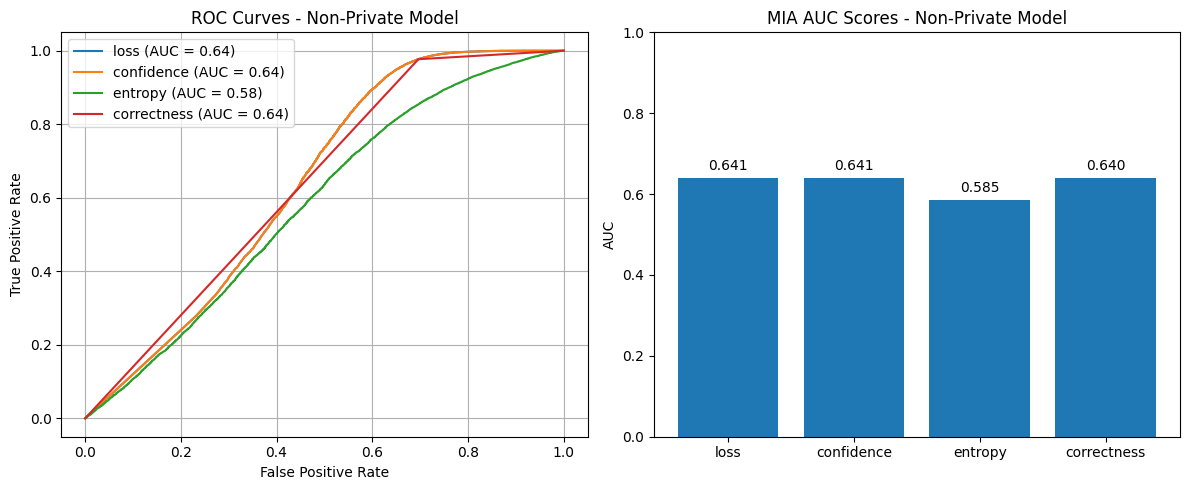

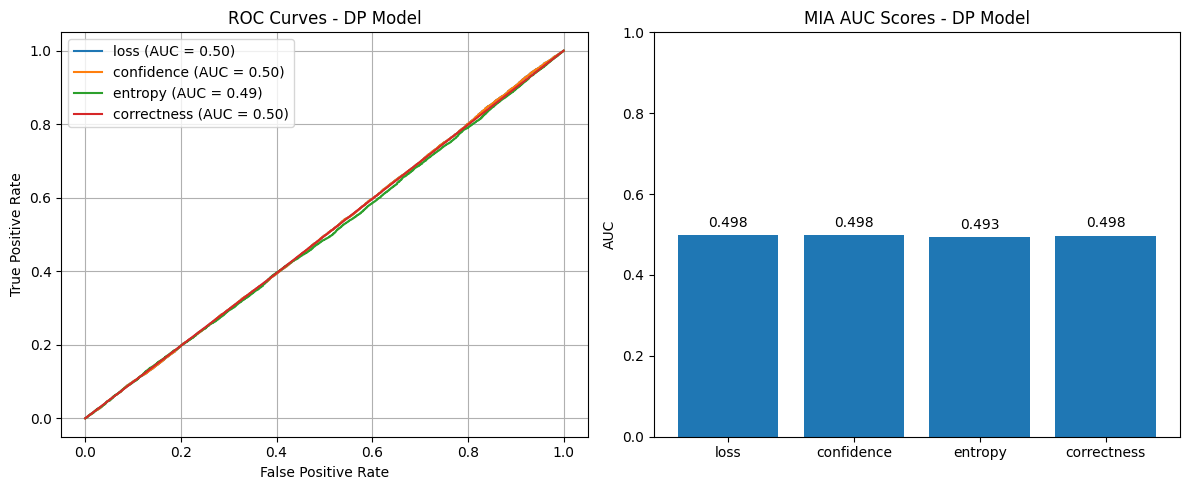

In [66]:
evaluate_mia(model_non_dp, mia_test_set, mia_test_set_labels, model_name="Non-Private Model")
evaluate_mia(model_dp, mia_test_set, mia_test_set_labels, model_name="DP Model")